In [1]:
%matplotlib inline

import os
import yaml

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import astropy.io.fits as pyfits
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.cosmology import WMAP9
from astropy.modeling.models import Schechter1D

import grizli
import grizli.catalog
from grizli import utils

from scipy.optimize import curve_fit
import pandas as pd

import eazy
import math

print(f'grizli version: {grizli.__version__}')
print(f'eazy-py version: {eazy.__version__}')

Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
grizli version: 1.11.2
eazy-py version: 0.6.8


### Set field & path
`abell2744clu` = Abell 2744 GLASS + UNCOVER + DD-2756

`gds` = GOODS-South

In [2]:
field = 'gds-grizli-v7.0' 
url_path = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7'

In [3]:
phot = utils.read_catalog(f'{url_path}/{field}-fix_phot_apcorr.fits')

In [4]:
import eazy.hdf5

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

root = f'{field}-fix'

self = eazy.hdf5.initialize_from_hdf5(h5file=root+'.eazypy.h5')
self.fit_phoenix_stars()

zout = utils.read_catalog(root+'.eazypy.zout.fits')
self.cat = utils.read_catalog(root+'_phot_apcorr.fits')
cat = self.cat

Read default param file: /home/codespace/.python/current/lib/python3.10/site-packages/eazy/data/zphot.param.default
CATALOG_FILE is a table
   >>> NOBJ = 52427
f090w_tot_1 f090w_etot_1 (363): jwst_nircam_f090w
f105w_tot_1 f105w_etot_1 (202): hst/wfc3/IR/f105w.dat
f110w_tot_1 f110w_etot_1 (241): hst/wfc3/IR/f110w.dat
f115w_tot_1 f115w_etot_1 (364): jwst_nircam_f115w
f115wn_tot_1 f115wn_etot_1 (309): niriss-f115w
f125w_tot_1 f125w_etot_1 (203): hst/wfc3/IR/f125w.dat
f140w_tot_1 f140w_etot_1 (204): hst/wfc3/IR/f140w.dat
f150w_tot_1 f150w_etot_1 (365): jwst_nircam_f150w
f150wn_tot_1 f150wn_etot_1 (310): niriss-f150w
f160w_tot_1 f160w_etot_1 (205): hst/wfc3/IR/f160w.dat
f182m_tot_1 f182m_etot_1 (370): jwst_nircam_f182m
f200w_tot_1 f200w_etot_1 (366): jwst_nircam_f200w
f200wn_tot_1 f200wn_etot_1 (311): niriss-f200w
f210m_tot_1 f210m_etot_1 (371): jwst_nircam_f210m
f277w_tot_1 f277w_etot_1 (375): jwst_nircam_f277w
f335m_tot_1 f335m_etot_1 (381): jwst_nircam_f335m
f356w_tot_1 f356w_etot_1 (376

294it [00:05, 55.13it/s]


h5: read corr_sfhz_13_bin0_av0.01.fits
h5: read corr_sfhz_13_bin0_av0.25.fits
h5: read corr_sfhz_13_bin0_av0.50.fits
h5: read corr_sfhz_13_bin0_av1.00.fits
h5: read corr_sfhz_13_bin1_av0.01.fits
h5: read corr_sfhz_13_bin1_av0.25.fits
h5: read corr_sfhz_13_bin1_av0.50.fits
h5: read corr_sfhz_13_bin1_av1.00.fits
h5: read corr_sfhz_13_bin2_av0.01.fits
h5: read corr_sfhz_13_bin2_av0.50.fits
h5: read corr_sfhz_13_bin2_av1.00.fits
h5: read corr_sfhz_13_bin3_av0.01.fits
h5: read corr_sfhz_13_bin3_av0.50.fits
h5: read fsps_4590.fits
h5: read j0647agn+torus.fits
fit_best: 30.7 s (n_proc=2,  NOBJ=51146)
phoenix_templates: ./bt-settl_t400-7000_g4.5.fits


Text(0.5, 1.0, 'JWST gds-grizli-v7.0')

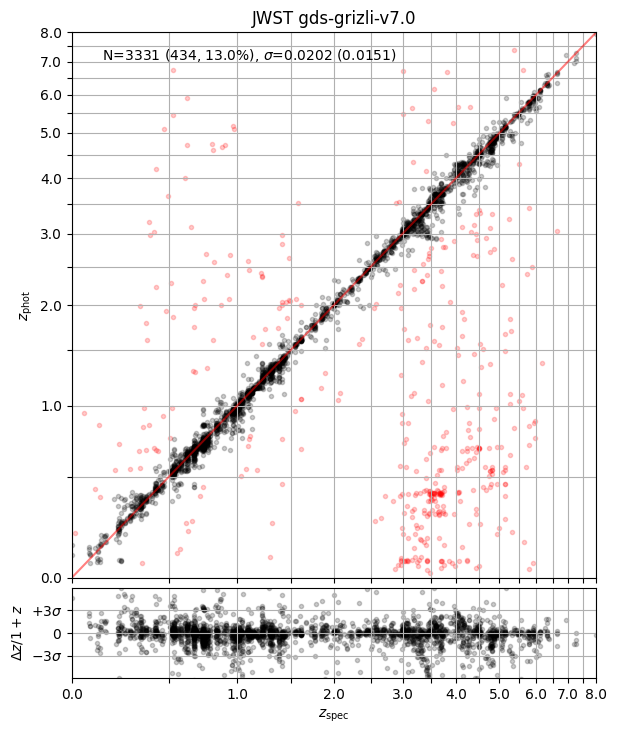

In [ ]:
fig = eazy.utils.zphot_zspec(zout['z_phot'], zout['z_spec'], zmax=8)
fig.axes[0].set_title(f'JWST {field}')

Text(0.5, 1.0, 'Photometric redshift distribution - Abell 2744')

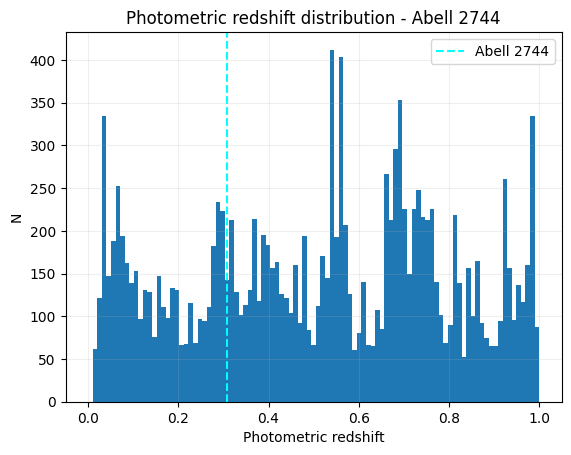

In [ ]:
plt.hist(zout['z_phot'], bins=np.linspace(0, 1, 100))
plt.axvline(0.308, linestyle='--', color='cyan', label='Abell 2744')
plt.grid(alpha=0.2)
plt.legend()
plt.xlabel('Photometric redshift'); plt.ylabel('N'); plt.title('Photometric redshift distribution - Abell 2744')

(18.0, 32.0)

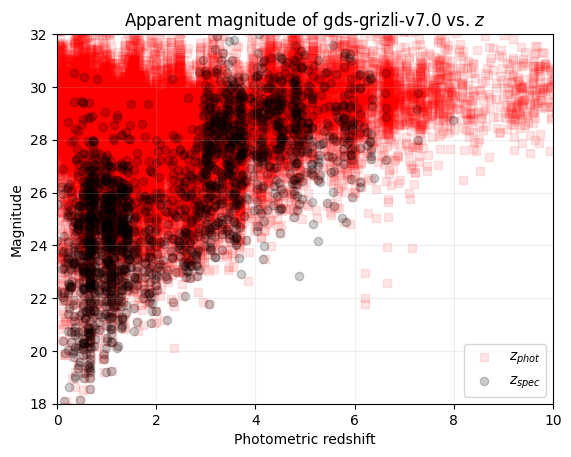

In [ ]:
mag_f200 = 23.9 - 2.5*np.log10(phot['f200w_tot_1']) # apparent magnitude using zero point of 23.9

plt.scatter(zout['z_phot'], mag_f200, marker='s', alpha=0.1, label='$z_{phot}$', color='red')
plt.scatter(zout['z_spec'], mag_f200, marker='o', alpha=0.2, label='$z_{spec}$', color='black')
plt.legend(); plt.title(f'Apparent magnitude of {field} vs. $z$')
plt.ylabel('Magnitude'); plt.xlabel('Photometric redshift')
plt.grid(alpha=0.2)
plt.xlim(0, 10); plt.ylim(18, 32)

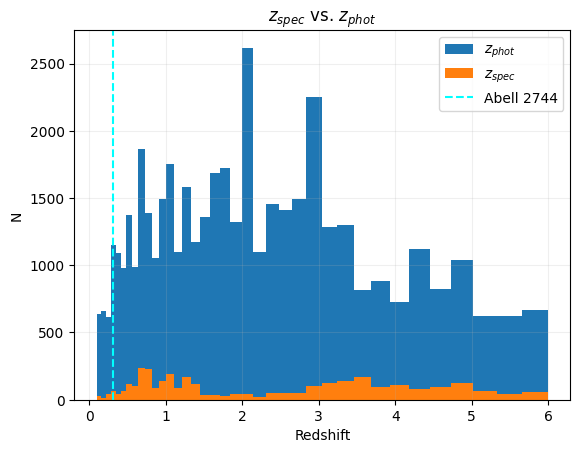

In [ ]:
plt.hist(zout['z_phot'], bins=eazy.utils.log_zgrid([0.1,6], 0.05), label='$z_{phot}$')
plt.hist(zout['z_spec'], bins=eazy.utils.log_zgrid([0.1,6], 0.05), label='$z_{spec}$')
plt.axvline(0.308, linestyle='--', color='cyan', label='Abell 2744')
plt.xlabel('Redshift'); plt.ylabel('N')
plt.grid(alpha=0.2)
plt.title('$z_{spec}$ vs. $z_{phot}$')
plt.legend()

## Colour-colour diagrams

In [10]:
# _rf = self.rest_frame_fluxes()

In [22]:
"""
_rf = (tf,lc,rf)
tf = rf integrated template fluxes (total through a filter)
lc = rf pivot wavelengths (effective wavelength based on filter's transmission properties)
rf = rf fluxes 
"""

_ubvj = _rf
UBVJ = [153,154,155,161]
self.ubvj_tempfilt, self.ubvj_lc, self.ubvj = _ubvj
self.ubvj_f_numbers = UBVJ
        
restU = self.ubvj[:,0,2] # flux density
restB = self.ubvj[:,1,2]
restV = self.ubvj[:,2,2]
restJ = self.ubvj[:,3,2]

UV = -2.5*np.log10(restU/restV) # rest-frame with AB magnitude
VJ = -2.5*np.log10(restV/restJ) 


In [11]:
restU = zout['restU']
restV = zout['restV']
restJ = zout['restJ']

UV = -2.5*np.log10(restU/restV) # rest-frame with AB magnitude
VJ = -2.5*np.log10(restV/restJ) 

In [12]:
# Creating a master dataframe of (z, U, V, J) in order to index by redshift
df = pd.DataFrame()

df['z_phot'] = list(zout['z_phot'])
df['U'] = list(restU)
df['V'] = list(restV)
df['J'] = list(restJ)
df['mag'] = mag_f200

df['mag'] = df['mag'].fillna(-1)
df = df[df['mag'] > -1] # only valid ones now

df

,z_phot,U,V,J,mag
5872,0.959798,0.029039,0.043250,0.055513,26.887958
5938,7.309223,0.003436,0.004568,0.003455,30.196616
5985,2.668844,0.377445,0.690842,1.998980,24.062776
5995,7.999544,0.003777,0.005444,0.033999,30.120811
5997,1.041048,0.021094,0.031414,0.026723,27.400796
...,...,...,...,...,...
52411,3.334347,0.195541,0.345498,0.610905,24.829368
52412,0.149985,0.004627,0.007035,0.008299,28.653487
52413,2.304484,0.006882,0.009370,0.006533,28.673403
52414,2.634876,0.067931,0.077191,0.057743,26.264426


In [13]:
def UVJ_diagram(df):
    """ For a given dataframe of shape (z, U, V, J, mag), 
        return the minimum and maximum z and UV and VJ bands
    """
    min_z = min(df['z_phot'])
    max_z = max(df['z_phot'])
    UV = -2.5*np.log10(df['U']/df['V'])
    VJ = -2.5*np.log10(df['V']/df['J'])
    
    return min_z, max_z, VJ, UV

def line(x):
    y = 0.857*x + 0.614
    return y

def plot_df_subsets(zs, cut='', alpha=0.1):
    """ Subplots for each range of z in zs (also cuts for magnitude if applicable)
    """
    fig, axs = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)
    fig.suptitle('UVJ Diagram - GDS' + ' (' + cut + ')')

    for i, variable in enumerate(zs):
        x = i//2; y = i%2 

        a, b = list(UVJ_diagram(zs[i])[2]), list(UVJ_diagram(zs[i])[3])

        for q in range(len(a)):
            if (a[q] < 0.8 and b[q] > 1.3) or (0.8 < a[q] < 1.5 and b[q] > line(a[q])) or (a[q] < 1.5 and b[q] > 1.9):
                axs[x,y].scatter(a[q], b[q], color='red', alpha=alpha, marker='*') 
            else:
                axs[x,y].scatter(a[q], b[q], color='tab:blue', alpha=alpha, marker='*') 

        axs[x,y].scatter(-1,2, color='red', alpha=0.5, marker='*', label='Quiescent') 
        axs[x,y].scatter(3,0.5, color='tab:blue', alpha=0.5, marker='*', label='Star-Forming') 
        axs[x,y].legend(loc='lower right', fontsize='x-small')

        axs[x,y].set_xlim(-0.5, 2.5); axs[x,y].set_ylim(0, 2.5)
        axs[x,y].text(-0.2, 2.2, str(round(UVJ_diagram(zs[i])[0], 2))+' $\leq$ z $\leq$ '+str(round(UVJ_diagram(zs[i])[1], 2)),fontsize=10)
        axs[x,y].set_xlabel('V-J')
        axs[x,y].set_ylabel('U-V')  

        axs[x,y].grid(alpha=0.7)

        # Plotting lines
        axs[x,y].plot([-0.5,0.8],[1.3,1.3],'k',lw=2) # left
        axs[x,y].plot([0.81,1.5],[1.3,1.9],'k',lw=2) # diag
        axs[x,y].plot([1.5,1.5],[1.9,2.5],'k',lw=2) # top

    plt.tight_layout()
    plt.show()

    return # concentrated cluster galaxies & background galaxies deviating in colour?

In [14]:
# Creating dataframes for different ranges of redshift

z1 = df[(df['z_phot'] >= 0.05) & (df['z_phot'] <= 0.25)]
z2 = df[(df['z_phot'] > 0.25) & (df['z_phot'] <= 0.35)] # explore more with this one
z3 = df[(df['z_phot'] > 0.35) & (df['z_phot'] <= 0.6)]
z4 = df[(df['z_phot'] > 0.6) & (df['z_phot'] <= 0.95)]
z5 = df[(df['z_phot'] > 0.95) & (df['z_phot'] <= 1.35)]
z6 = df[(df['z_phot'] > 1.35) & (df['z_phot'] <= 1.90)]

zs=[z1,z2,z3,z4 ,z5, z6]

c = 0
for z in zs:
    print(len(z))
    c += (len(z))

print(c / len(df) * 100, '%')

1592
646
2429
2600
3145
3139
46.06363450948399 %


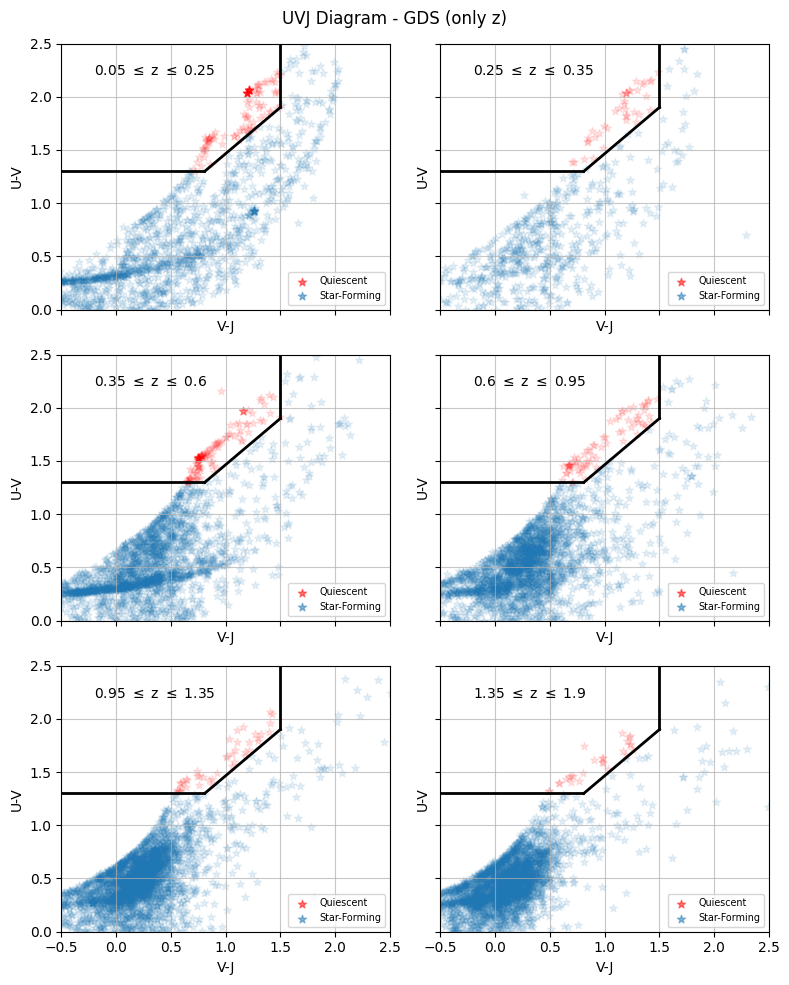

In [35]:
plot_df_subsets(zs, cut='only z')

## Magnitude

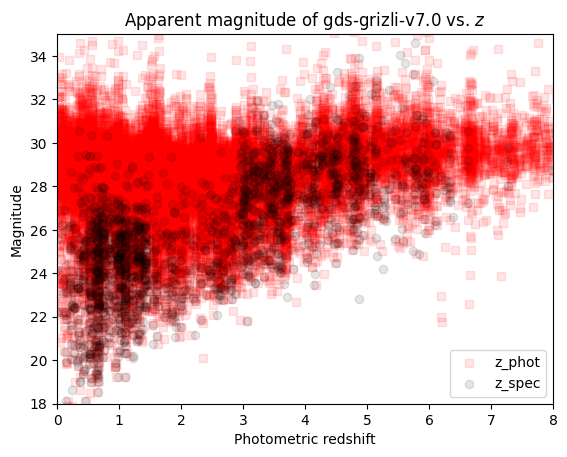

In [38]:
plt.scatter(zout['z_phot'], mag_f200, marker='s', alpha=0.1, label='z_phot', color='red')
plt.scatter(zout['z_spec'], mag_f200, marker='o', alpha=0.1, label='z_spec', color='black')
plt.title(f'Apparent magnitude of {field} vs. $z$')
plt.ylabel('Magnitude'); plt.xlabel('Photometric redshift')

plt.xlim(0, 8); plt.ylim(18, 35)
plt.legend()

In [39]:
# Creating dataframes for different ranges of magnitude (on top of redshift)
ms = []

for z in zs:
    m_cut = z[(z['mag'] >= 18) & (z['mag'] <= 23)]
    ms.append(m_cut)

for m in ms:
    print(len(m))

31
12
50
84
73
34


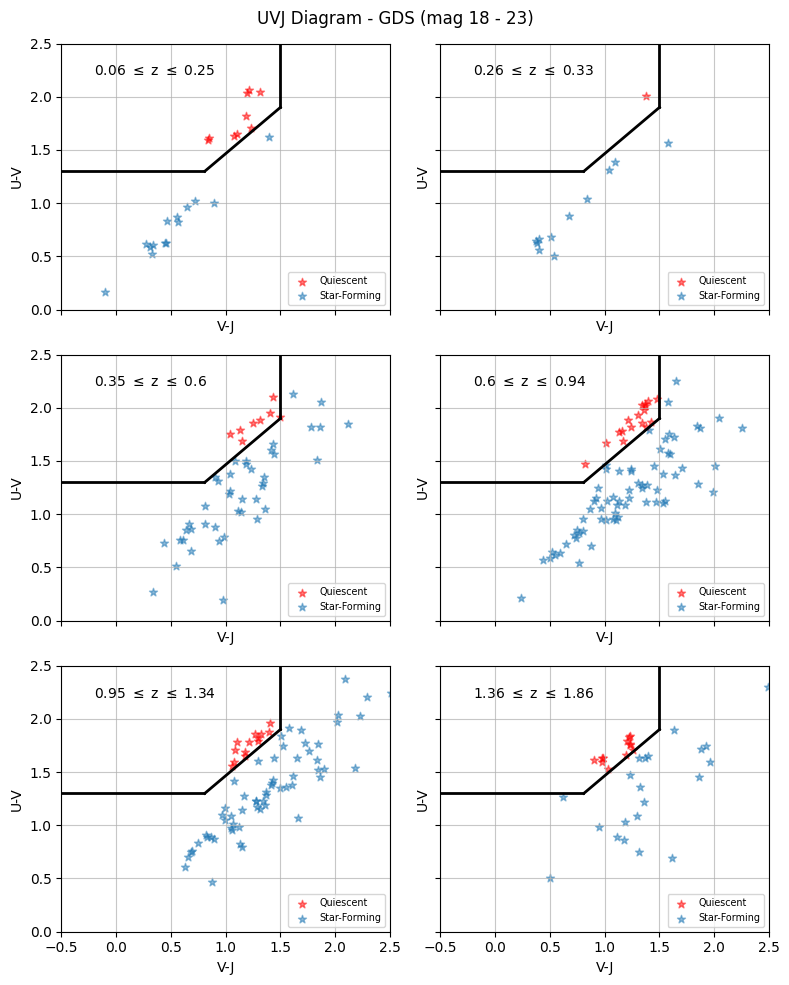

In [41]:
plot_df_subsets(ms, cut='mag 18 - 23', alpha=0.5)

## Luminosity function

0 4
1 19
2 29
3 35
4 47
5 73
6 84
7 91
8 95
9 103
10 108
11 109
12 142
13 145
14 184
15 194
16 202
17 203
18 235
19 244
20 246
21 250
22 251
23 265
24 270
25 273
26 278
27 288
28 289
29 311
30 325
31 327
32 345
33 382
34 403
35 409
36 413
37 428
38 429
39 430
40 475
41 485
42 487
43 511
44 528
45 534
46 555
47 565
48 594
49 595
50 599
51 614
52 619
53 631
54 638
55 640
56 694
57 698
58 708
59 716
60 718
61 720
62 723
63 725
64 740
65 747
66 748
67 752
68 769
69 785
70 798
71 805
72 806
73 818
74 822
75 823
76 825
77 852
78 855
79 856
80 861
81 885
82 893
83 894
84 906
85 909
86 930
87 949
88 953
89 971
90 985
91 991
92 996
93 1003
94 1006
95 1008
96 1020
97 1028
98 1032
99 1054
100 1060
101 1074
102 1083
103 1087
104 1098
105 1116
106 1120
107 1154
108 1206
109 1213
110 1218
111 1242
112 1252
113 1273
114 1275
115 1286
116 1287
117 1288
118 1290
119 1294
120 1299
121 1308
122 1316
123 1321
124 1322
125 1323
126 1345
127 1348
128 1349
129 1380
130 1384
131 1415
132 1426
133 1448
134 145

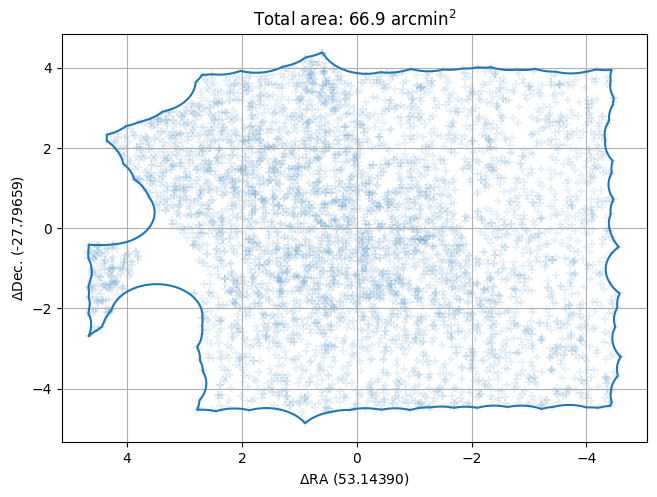

In [52]:
area, area_fig = grizli.utils.catalog_area(phot['ra'], phot['dec']) # square arcminutes

In [46]:
# Calculate phi_star
def normalization_param(z1, z2, area, N, mag):
    """ Calculates the normalization parameter, phi_star, of the Schechter luminosity function
        z1, z2: differential redshift (should correspond to redshift of magnitudes inputted)
        area: catalog area (unitless)
        N: number of galaxies total
        mag: list of magnitudes
    """
    area *=  u.arcmin**2
    area_ster = area.to(u.steradian, equivalencies=u.dimensionless_angles())
    vol_in = WMAP9.comoving_volume(z1)
    vol_out = WMAP9.comoving_volume(z2)
    vol_area = (area_ster / ((2 * np.pi)*u.steradian)) * abs(vol_out-vol_in) # vol * area
    mag_diff =  u.Magnitude((max(mag) - min(mag)))
    return N / (mag_diff * vol_area)

# Schechter function:
def schechter(mag, scale_factor=11, M_star=-21.9,a=-1.21): # use scipy to fit values for m_star, a, phi, also look at literature
    func = scale_factor * 0.4*np.log(10) * (10**(0.4*(M_star-mag)))**(a+1) / np.exp(10**(0.4*(M_star-mag)))   
    return func

# Plot Schechter function
def plot_sch(phi_star, m_star, alpha, mag, hist=False):
    """ phi_star = normalization factor in units of number density
        m_star = characteristic magnitude where  power-law form cuts off into the exponential form
        alpha = power-law index (faint-end slope of the luminosity function)
    """
    phi_star = phi_star * (u.Mpc ** -3)
    m_star = m_star
    alpha = alpha
    model = schechter(mag, phi_star, m_star, alpha) # Schechter1D(phi_star, m_star, alpha)

    if hist:
        plt.hist(mag, bins=np.linspace(-23, -18, 50), alpha=0.5, weights=phi_star*np.ones_like(mag))

    plt.scatter(mag, model, label='Schechter Function') # model(new_mag)
    plt.yscale('log')
    plt.xlabel('$M_{F200}$'); plt.ylabel('$\phi^{*} [Mpc^{-3} {mag}^{-1}$]')
    plt.title('Schechter Luminosity Function')
    plt.xlim(-23, -18)
    plt.grid(alpha=0.3)

    return model

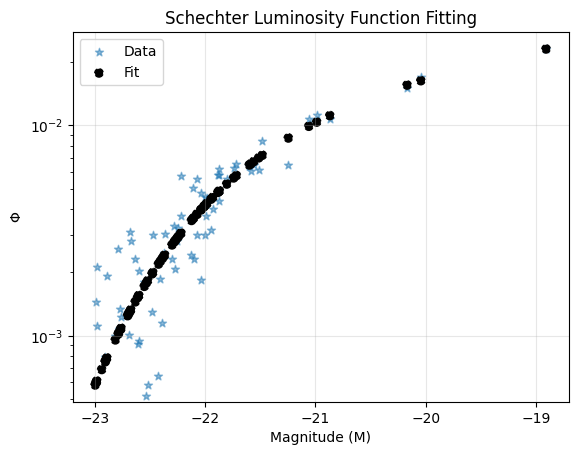

[ 1.52217818e-02 -2.18233997e+01 -1.21183395e+00]


In [62]:
### Curve-fitting LF
mag = ms[4]['mag'] # magnitudes 18-23, redshift 0.29-0.31
x_data = mag * -1 
model = schechter(x_data, scale_factor=normalization_param(0.29, 0.31, area, len(mag), mag), M_star=-21.9, a=-1.21)
y_data = model + np.random.normal(0, 0.001, len(model))  ## with noise

def func(M, phi_star, m_star, alpha):
    return schechter(M, phi_star, m_star, alpha)

popt, pcov = curve_fit(func, x_data, y_data, p0=[1e-2, -20, -1.5]) # initial guess

plt.scatter(x_data, y_data, label='Data', alpha=0.5, marker='*')
plt.scatter(x_data, func(x_data, *popt), label='Fit', color='k', linestyle='--')
plt.xlabel('Magnitude (M)'); plt.ylabel('$\Phi$')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.title('Schechter Luminosity Function Fitting')
plt.legend()
plt.show()

print(popt)

## Star formation rate!

In [53]:
# Creating a master dataframe of stellar masses etc
stellar_df = pd.DataFrame()

stellar_df['stellar_mass'] = list(zout['mass'])
stellar_df['sfr'] = list(zout['sfr'])
stellar_df['z'] = list(zout['z_phot'])
stellar_df['dL'] = list(zout['dL']) # Mpc
stellar_df['app_mag'] = list(23.9 - 2.5*np.log10(phot['f200w_tot_1'] / 23.9)) #list(23.9 - 2.5*np.log10(phot['f200w_tot_1']))

stellar_df = stellar_df[stellar_df['stellar_mass'] > 0] # only valid ones now

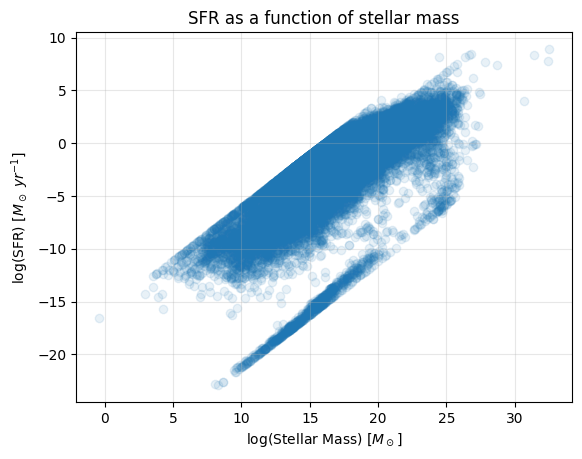

In [54]:
plt.scatter(np.log(stellar_df['stellar_mass']), np.log(stellar_df['sfr']), alpha=0.1)
plt.xlabel('log(Stellar Mass) [$M_\odot$]'); plt.ylabel('log(SFR) [$M_\odot \ yr^{-1}$]')
plt.title('SFR as a function of stellar mass')
plt.grid(alpha=0.3)

In [55]:
def smf(phi_star, M_star, M_char, a):
    phi = np.log(10) * phi_star * np.exp(-10**(np.log10(M_star) - np.log10(M_char))) * (10**(np.log10(M_star)-np.log10(M_char)))**(a+1)
    return phi

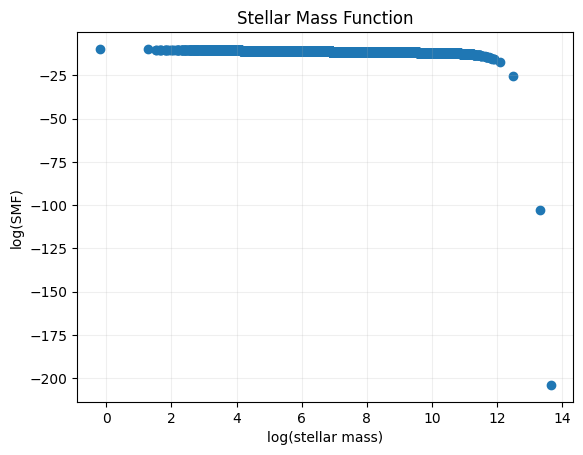

In [58]:
norm = normalization_param(0.29, 0.31, area, len(stellar_df['stellar_mass']), stellar_df['stellar_mass'])

plt.scatter(np.log10(stellar_df['stellar_mass']), np.log10(smf(phi_star=norm, M_star=stellar_df['stellar_mass'], M_char=10**11, a=-1.21)))
plt.xlabel('log(stellar mass)'); plt.ylabel('log(SMF)')
plt.title('Stellar Mass Function')
plt.grid(alpha=0.2)

5336099065380.414 Mpc3


Text(0.5, 0, 'z')

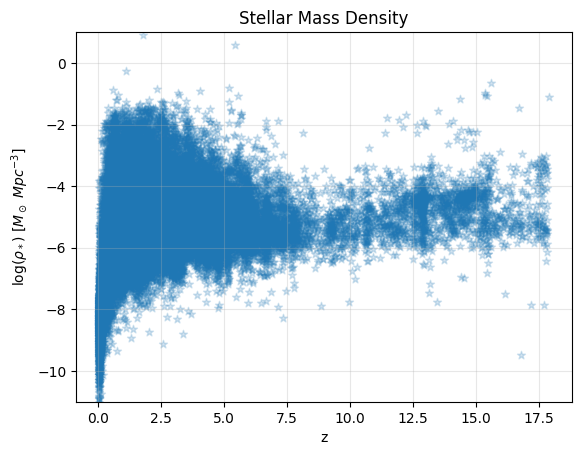

In [59]:
vol_in = WMAP9.comoving_volume(min(stellar_df['z']))
vol_out = WMAP9.comoving_volume(max(stellar_df['z']))
vol = vol_out - vol_in
print(vol)

plt.title('Stellar Mass Density')
plt.grid(alpha=0.3)
plt.scatter(stellar_df['z'], np.log10(stellar_df['stellar_mass']/vol), alpha=0.2, marker='*')
plt.ylim(-11, 1)
plt.ylabel('log($\\rho_*$) [$M_\odot\ Mpc^{-3}$]'); plt.xlabel('z')